# Sentiment Analysis of Bank Customers

## Goals:

This project intends to determine by prediction and analyze the likelihood of bank customers churning from using a bank's products and services. The sentiments of the customers are determined from the customer's rating of the bank's product and service.

## Data

The dataset contains series of features and the label variable that determines the likelihood of customers churning will be classified into three groups: -1 (negative sentiment), 0 (neutral) and 1 (positive). I intended to use machine learning model to predict customers' sentiments regarding the bank's product. This will enable the stakeholders to determine the likelihood of customers' retention and churn. The dataset for the this project can be downloded from [bank_customer](https://drive.google.com/file/d/1UjSuDU7eIWC_OUHbKiOgTZu4mcfC1bUc/view?usp=sharing)

## Highlights

The following will be done:

1. Prepare Data:

    * Import libraries
    * Define relevant functions for analysis
    * Import data
    * Explore data: Assess, clean, re-assess data, preprocess data and EDA
    * Split data:
    
2. Build Model:

    * Baseline
    * Iterate/ Train model
    * Evaluate Model

3. Communicate Result

    * Save model
    * Observations
    * Some possible causes of the problem
    * Recommendations
    * Conclusion

## Prepare Data

### Import libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Import pickle and regex for saving model
import  pickle, re

# COllections
from collections import Counter

# Import NLP package
import string
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk import RegexpTokenizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS


# Model selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (train_test_split, cross_validate)
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

# Resampling technique for imbalance dataset
from imblearn.over_sampling import RandomOverSampler,SMOTENC,SMOTE, SVMSMOTE

# Model evaluation
from sklearn.metrics import (roc_auc_score, roc_curve, classification_report,confusion_matrix,
                             ConfusionMatrixDisplay, accuracy_score, log_loss, precision_score,
                             recall_score, auc, RocCurveDisplay, f1_score)

# For feature preprocessing, normalizing and extraction
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

%matplotlib inline


### Define relevant functions

In [115]:
# Define relevant functions for analysis

# Define function that loads dataset into the environment
def wrangle_data(filename: str) -> pd.DataFrame:
    data = pd.read_csv(filename)

    # Drop duplicates
    data = data.copy()
    data.drop_duplicates(inplace=True)

    # Drop missing values
    data.dropna(axis=0, inplace=True)

    # Return data
    return data


# Define tokenized function
# Note that 's' stands for strings and 't' stands for text
def preprocess_text(s):
    # Remove punctuation marks from text
    no_punc = [t for t in s if t not in string.punctuation]
    # Remove numerical values from text
    no_digit = "".join([i for i in no_punc if not i.isdigit()])
    # Remove stopwords. Change all string characters to lowercase
    clean_word = [w for w in no_digit.split() if w.lower() not in stopwords.words("english")]

    # Returning clean data
    return clean_word



# Define function that compares predicted label and actual value
def predicted_result(y_true: np.ndarray, y_pred: np.ndarray) -> pd.DataFrame:
    """Returns new pandas dataframe containing true and predicted labels
    
    Params:
    y_true -- np.ndarray, the initial target variable
    y_pred - np.ndarray, the predicted target variable
    Return: Pandas Dataframe of the true and predicted target variables
    """
    result = pd.DataFrame()
    result["y_true"] = y_true
    result["y_pred"] = y_pred
    result["error_term"] = (y_true - y_pred)

    return result


# Define function predicting label variable
def predict_label(X, model) -> "np.ndarray":
    """Returns the predicted series label
    
    Params:
    X -- pd.DataFrame, inputs the feature variables
    model_type -- inputs the model type

    Return: The predicted label variable as pandas Series object 
    """
    y_pred = model.predict(X)
    return y_pred


# Define function for Confusion matrix
def confusion_mat(model, X, y, model_name):
    ConfusionMatrixDisplay.from_estimator(model, X, y)
    plt.title(f"Confusion Matrix: {model_name.title()}")
    # plt.savefig(f"Confusion_mat_{model_name}.jpg", bbox_inches='tight', dpi=150);

# Define function to predict probability
def proba_test_score(model, X):
    y_proba = model.predict_proba(X)[: ,1]
    return y_proba


# Define function to get the ROC curve and AUC
def get_auc_roc_curve(y, y_proba, model_name:str):
    fpr, tpr, thresholds = roc_curve(y_true=y, y_score=y_proba)
    roc_auc = auc(fpr, tpr)
    # Plot the ROC curve
    plt.plot(fpr, tpr, label= f'ROC curve area={round(roc_auc,2)}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic (ROC) curve: {model_name.title()}')
    plt.legend(loc="lower right")
    # plt.savefig(f"auc_roc_curve_{model_name}.jpg", bbox_inches='tight', dpi=150);


# Define function that saves model as file
def save_model(model, filename: str):
    with open(filename, "wb") as file:
        pickle.dump(model, file)


# Define function to get the model metrics
def eval_metrics(y_true, y_pred, y_proba):

    acc_score = accuracy_score(y_true=y_true, y_pred=y_pred)
    prec_score = precision_score(y_true=y_true, y_pred=y_pred, average="weighted")
    recall = recall_score(y_true=y_true, y_pred=y_pred, average="weighted")
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average="weighted")
    return (
        {
        "accuracy":round(acc_score, 4),
        "precision":round(prec_score, 4),
        "recall":round(recall, 4),
        "f1_score": round(f1, 4)
        }
    )
    

# Define function for model selection
def eval_best_model(model_1, model_2,model_3,model_4,model_5,model_6,
                    X_train, X_test, y_train, y_test):
    for m in [model_1, model_2,model_3,model_4,model_5,model_6]:
        train_acc = m.score(X_train, y_train)
        test_acc = m.score(X_test, y_test)
        # Print accuracy scores
        print(f"Model accuracy for:{m}")
        print(f"Training Accuracy: {round(train_acc, 4)}")
        print(f"Test Accuracy: {round(test_acc, 4)}")
        print("="*50)



# Define function to plot most frequent words on wordcloud
def plot_freq_word(data: pd.DataFrame, feature: str, title):
    # Plot the frequent word on wordcloud
    plt.figure(figsize=[10,5])
    wordcld = WordCloud().generate(str(data[feature]))
    plt.xlabel(f"{feature}")
    plt.ylabel("Frequency")
    plt.title(f"Plot of {title}")
    plt.imshow(wordcld);


# Define a function for the bag of words
def text_bow(txt):
    txt_counter = Counter(txt)
    return txt_counter  


# Define function form customer's sentiment
def sentiment(rate):
    # Neutral sentiment
    res = 0
    # Negative sentiment
    if (rate == 'Dissatisfied') or (rate == "Very Dissatisfied"):
        res = -1
    # Positive sentiment
    elif (rate == "Very Satisfied") or (rate == "Satisfied"):
        res = 1

    # Return result
    return res


# Plot for categorical variables

# Creating functions for numeric variables plots
def cat_plot(data: pd.DataFrame, features: list[str]) -> 'plots':
    """Returns barchart for categorical data

    Params:
        data :pd.DataFrame, returns the loaded data
        features: list[str], returns list of features
    """
    plt.figure(figsize=(30,22))
    for i, feat in enumerate(features):
        base_color = sns.color_palette()[0]
        plt.subplot(4,3,i+1)
        axs = sns.countplot(data=data, x=data[feat])
        axs.set_title(f"Bar plot for: {feat.title()}")
        axs.set_xlabel(f"{feat.title()}")
        axs.set_ylabel('Frequency')
        plt.xticks(rotation=45)
        var_max = data[feat].value_counts().idxmax()
        var_max_val = data[feat].value_counts()[0]
        var_min = data[feat].value_counts().idxmin()
        var_min_val = data[feat].value_counts()[-1]
        print('{} has the largest occurence'.format(var_max),
        'with value',var_max_val)
        print('{} has the smallest occurence'.format(var_min),
        'with value',var_min_val)
        print("="*70)

    plt.tight_layout();


def bar_plot(data: pd.DataFrame, features: list[str], other) -> 'plots':
    """Returns barchart for categorical data against sentiment feature

    Params:
        data :pd.DataFrame, returns the loaded data
        features: list[str], returns list of features
        other: str, returns the feature variable
    """
    plt.figure(figsize=(30,22))
    for i, feat in enumerate(features):
        # plt.rcParams.update({'font.size': 14})
        base_color = sns.color_palette()[0]
        plt.subplot(4,3,i+1)
        axs = sns.countplot(data=data, x=data[feat], hue=other)
        axs.set_title(f"Bar plot for: {feat.title()}")
        axs.set_xlabel(f"{feat.title()}")
        axs.set_ylabel('Frequency')
        plt.xticks(rotation=45)

    plt.tight_layout();



def cat_pie_plot(data: pd.DataFrame, features: list[str]) -> 'plots':
    """Returns pie chart for categorical variables

    Params:
        data :pd.DataFrame, returns the loaded data
        features: list[str], returns list of features
    """
    plt.figure(figsize=(30,17))
    for i, feat in enumerate(features):
        base_color = sns.color_palette()[0]
        plt.subplot(3,4,i+1)
        freq = data[feat].value_counts()
        var = data[feat].value_counts().index
        axs = plt.pie(freq, labels=var,startangle=90, autopct="%.1f%%")
        plt.legend()
        plt.title("Pie chart: {}".format(feat.title()))

    plt.tight_layout();

# Plot customers' sentiment
def pie_plot(data, feat:str):
    """Return pie plot for the sentiment analysis

    Args:
        data (pd.DataFrame): The dataframe of the dataset
        feat (str): The sentiment variable
    """
    plt.figure(figsize=[7,7])
    freq = data[str(feat)].value_counts()
    var = data[str(feat)].value_counts().index
    label_var = {var[0]:"Positive",var[1]:"Neutral",var[2]:"Negative"}
    axs = plt.pie(freq, labels=var,startangle=90, autopct="%.1f%%")
    plt.title("Sentiment Analysis")
    plt.legend(label_var.values(),title="Sentiments");


# Plot bar chart for sentiment
def sentiment_bar_plot(data, feat:str):
    plt.figure(figsize=[9,5])
    indx = data[str(feat)].value_counts().index
    freq = data[str(feat)].value_counts()
    label_var = {indx[0]:"Positive",indx[1]:"Neutral",indx[2]:"Negative"}
    sns.barplot(data=data, x=indx, y=freq)
    plt.legend(label_var.values(),title="Sentiments");


### Import and wrangle data

In [3]:
df = wrangle_data("beta customers.csv")
df.head()

,Gender,Age Range,"How did you hear about our BETA Savings account? Advert, Beta Friends, Friends, Family, Others",Do you know your BETA friend,Do you know about our Target Savings account?,How satisfied are you with your BETA account?,Do your requests get treated in a timely manner?,Please rate your experience with your BETA Friend,How do you resolve your complaints?,Will you be interested in loan offerings from us?,Did you know you can use our USSD services on *614*045# to check your balance and buy airtime?,Please tell us how best we can serve you
0,Male,25-34,BETA Friends,Yes,No,Very Satisfied,Yes,Excellent,Talk to a BETA friend,Yes,Yes,more visit by BETA friend and gift items
1,Female,25-34,BETA Friends,Yes,Yes,Very Satisfied,Yes,Excellent,Talk to a BETA friend,No,Yes,They should improve in beta account so we can ...
2,Male,35-44,BETA Friends,Yes,No,Very Satisfied,Yes,Excellent,Talk to a BETA friend,No,Yes,Ensure I can make transfer on my beta acct
3,Male,35-44,BETA Friends,Yes,No,Very Satisfied,Yes,Excellent,Talk to a BETA friend,No,Yes,Enable the account on mobile banking
4,Male,35-44,BETA Friends,Yes,Yes,Very Satisfied,Yes,Excellent,Talk to a BETA friend,No,Yes,SMS Alert


In [4]:
# Investigate dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 874 entries, 0 to 921
Data columns (total 12 columns):
 #   Column                                                                                          Non-Null Count  Dtype 
---  ------                                                                                          --------------  ----- 
 0   Gender                                                                                          874 non-null    object
 1   Age Range                                                                                       874 non-null    object
 2   How did you hear about our BETA Savings account? Advert, Beta Friends, Friends, Family, Others  874 non-null    object
 3   Do you know your BETA friend                                                                    874 non-null    object
 4   Do you know about our Target Savings account?                                                   874 non-null    object
 5   How satisfied are you 

In [5]:
# Check for duplicated values
df.duplicated().sum()

0

In [6]:
# Check for missing values
df.isna().sum()

Gender                                                                                            0
Age Range                                                                                         0
How did you hear about our BETA Savings account? Advert, Beta Friends, Friends, Family, Others    0
Do you know your BETA friend                                                                      0
Do you know about our Target Savings account?                                                     0
How satisfied are you with your BETA account?                                                     0
Do your requests get treated in a timely manner?                                                  0
Please rate your experience with your BETA Friend                                                 0
How do you resolve your complaints?                                                               0
Will you be interested in loan offerings from us?                                                 0


In [7]:
df["How satisfied are you with your BETA account?"].value_counts()

Very Satisfied       380
Satisfied            363
Neutral               94
Dissatisfied          28
Very Dissatisfied      9
Name: How satisfied are you with your BETA account?, dtype: int64

In [8]:
# Add a sentiment column
df["Sentiment"] = df["How satisfied are you with your BETA account?"].apply(sentiment)

# Drop the original variable
df.drop(columns="How satisfied are you with your BETA account?", inplace=True)
df.head()

,Gender,Age Range,"How did you hear about our BETA Savings account? Advert, Beta Friends, Friends, Family, Others",Do you know your BETA friend,Do you know about our Target Savings account?,Do your requests get treated in a timely manner?,Please rate your experience with your BETA Friend,How do you resolve your complaints?,Will you be interested in loan offerings from us?,Did you know you can use our USSD services on *614*045# to check your balance and buy airtime?,Please tell us how best we can serve you,Sentiment
0,Male,25-34,BETA Friends,Yes,No,Yes,Excellent,Talk to a BETA friend,Yes,Yes,more visit by BETA friend and gift items,1
1,Female,25-34,BETA Friends,Yes,Yes,Yes,Excellent,Talk to a BETA friend,No,Yes,They should improve in beta account so we can ...,1
2,Male,35-44,BETA Friends,Yes,No,Yes,Excellent,Talk to a BETA friend,No,Yes,Ensure I can make transfer on my beta acct,1
3,Male,35-44,BETA Friends,Yes,No,Yes,Excellent,Talk to a BETA friend,No,Yes,Enable the account on mobile banking,1
4,Male,35-44,BETA Friends,Yes,Yes,Yes,Excellent,Talk to a BETA friend,No,Yes,SMS Alert,1


In [9]:
# Rename text (feature) variable
remapper = {"Please tell us how best we can serve you":"text"}
df.rename(columns=remapper, inplace=True)

### Preprocess data

In [10]:
vectorizer = CountVectorizer(analyzer=preprocess_text).fit_transform(df["text"])

### Explore data

In [12]:
# Select categorical variables
cat_var = df.select_dtypes("object").drop(columns="text")
cat_var.columns

Index(['Gender', 'Age Range',
       'How did you hear about our BETA Savings account? Advert, Beta Friends, Friends, Family, Others',
       'Do you know your BETA friend',
       'Do you know about our Target Savings account?',
       'Do your requests get treated in a timely manner?',
       'Please rate your experience with your BETA Friend',
       'How do you resolve your complaints?',
       'Will you be interested in loan offerings from us?',
       'Did you know you can use our USSD services on *614*045# to check your balance and buy airtime?'],
      dtype='object')

In [13]:
num_var = df.select_dtypes("number")
num_var.columns

Index(['Sentiment'], dtype='object')

Male has the largest occurence with value 522
Female has the smallest occurence with value 352
35-44 has the largest occurence with value 387
60 & above has the smallest occurence with value 15
BETA Friends has the largest occurence with value 797
Others has the smallest occurence with value 3
Yes has the largest occurence with value 871
No has the smallest occurence with value 3
Yes has the largest occurence with value 790
No has the smallest occurence with value 84
Yes has the largest occurence with value 765
No has the smallest occurence with value 109
Excellent has the largest occurence with value 491
Poor has the smallest occurence with value 3
Talk to a BETA friend has the largest occurence with value 713
Call our contact center team has the smallest occurence with value 4
No has the largest occurence with value 464
Yes has the smallest occurence with value 410
Yes has the largest occurence with value 773
No has the smallest occurence with value 101


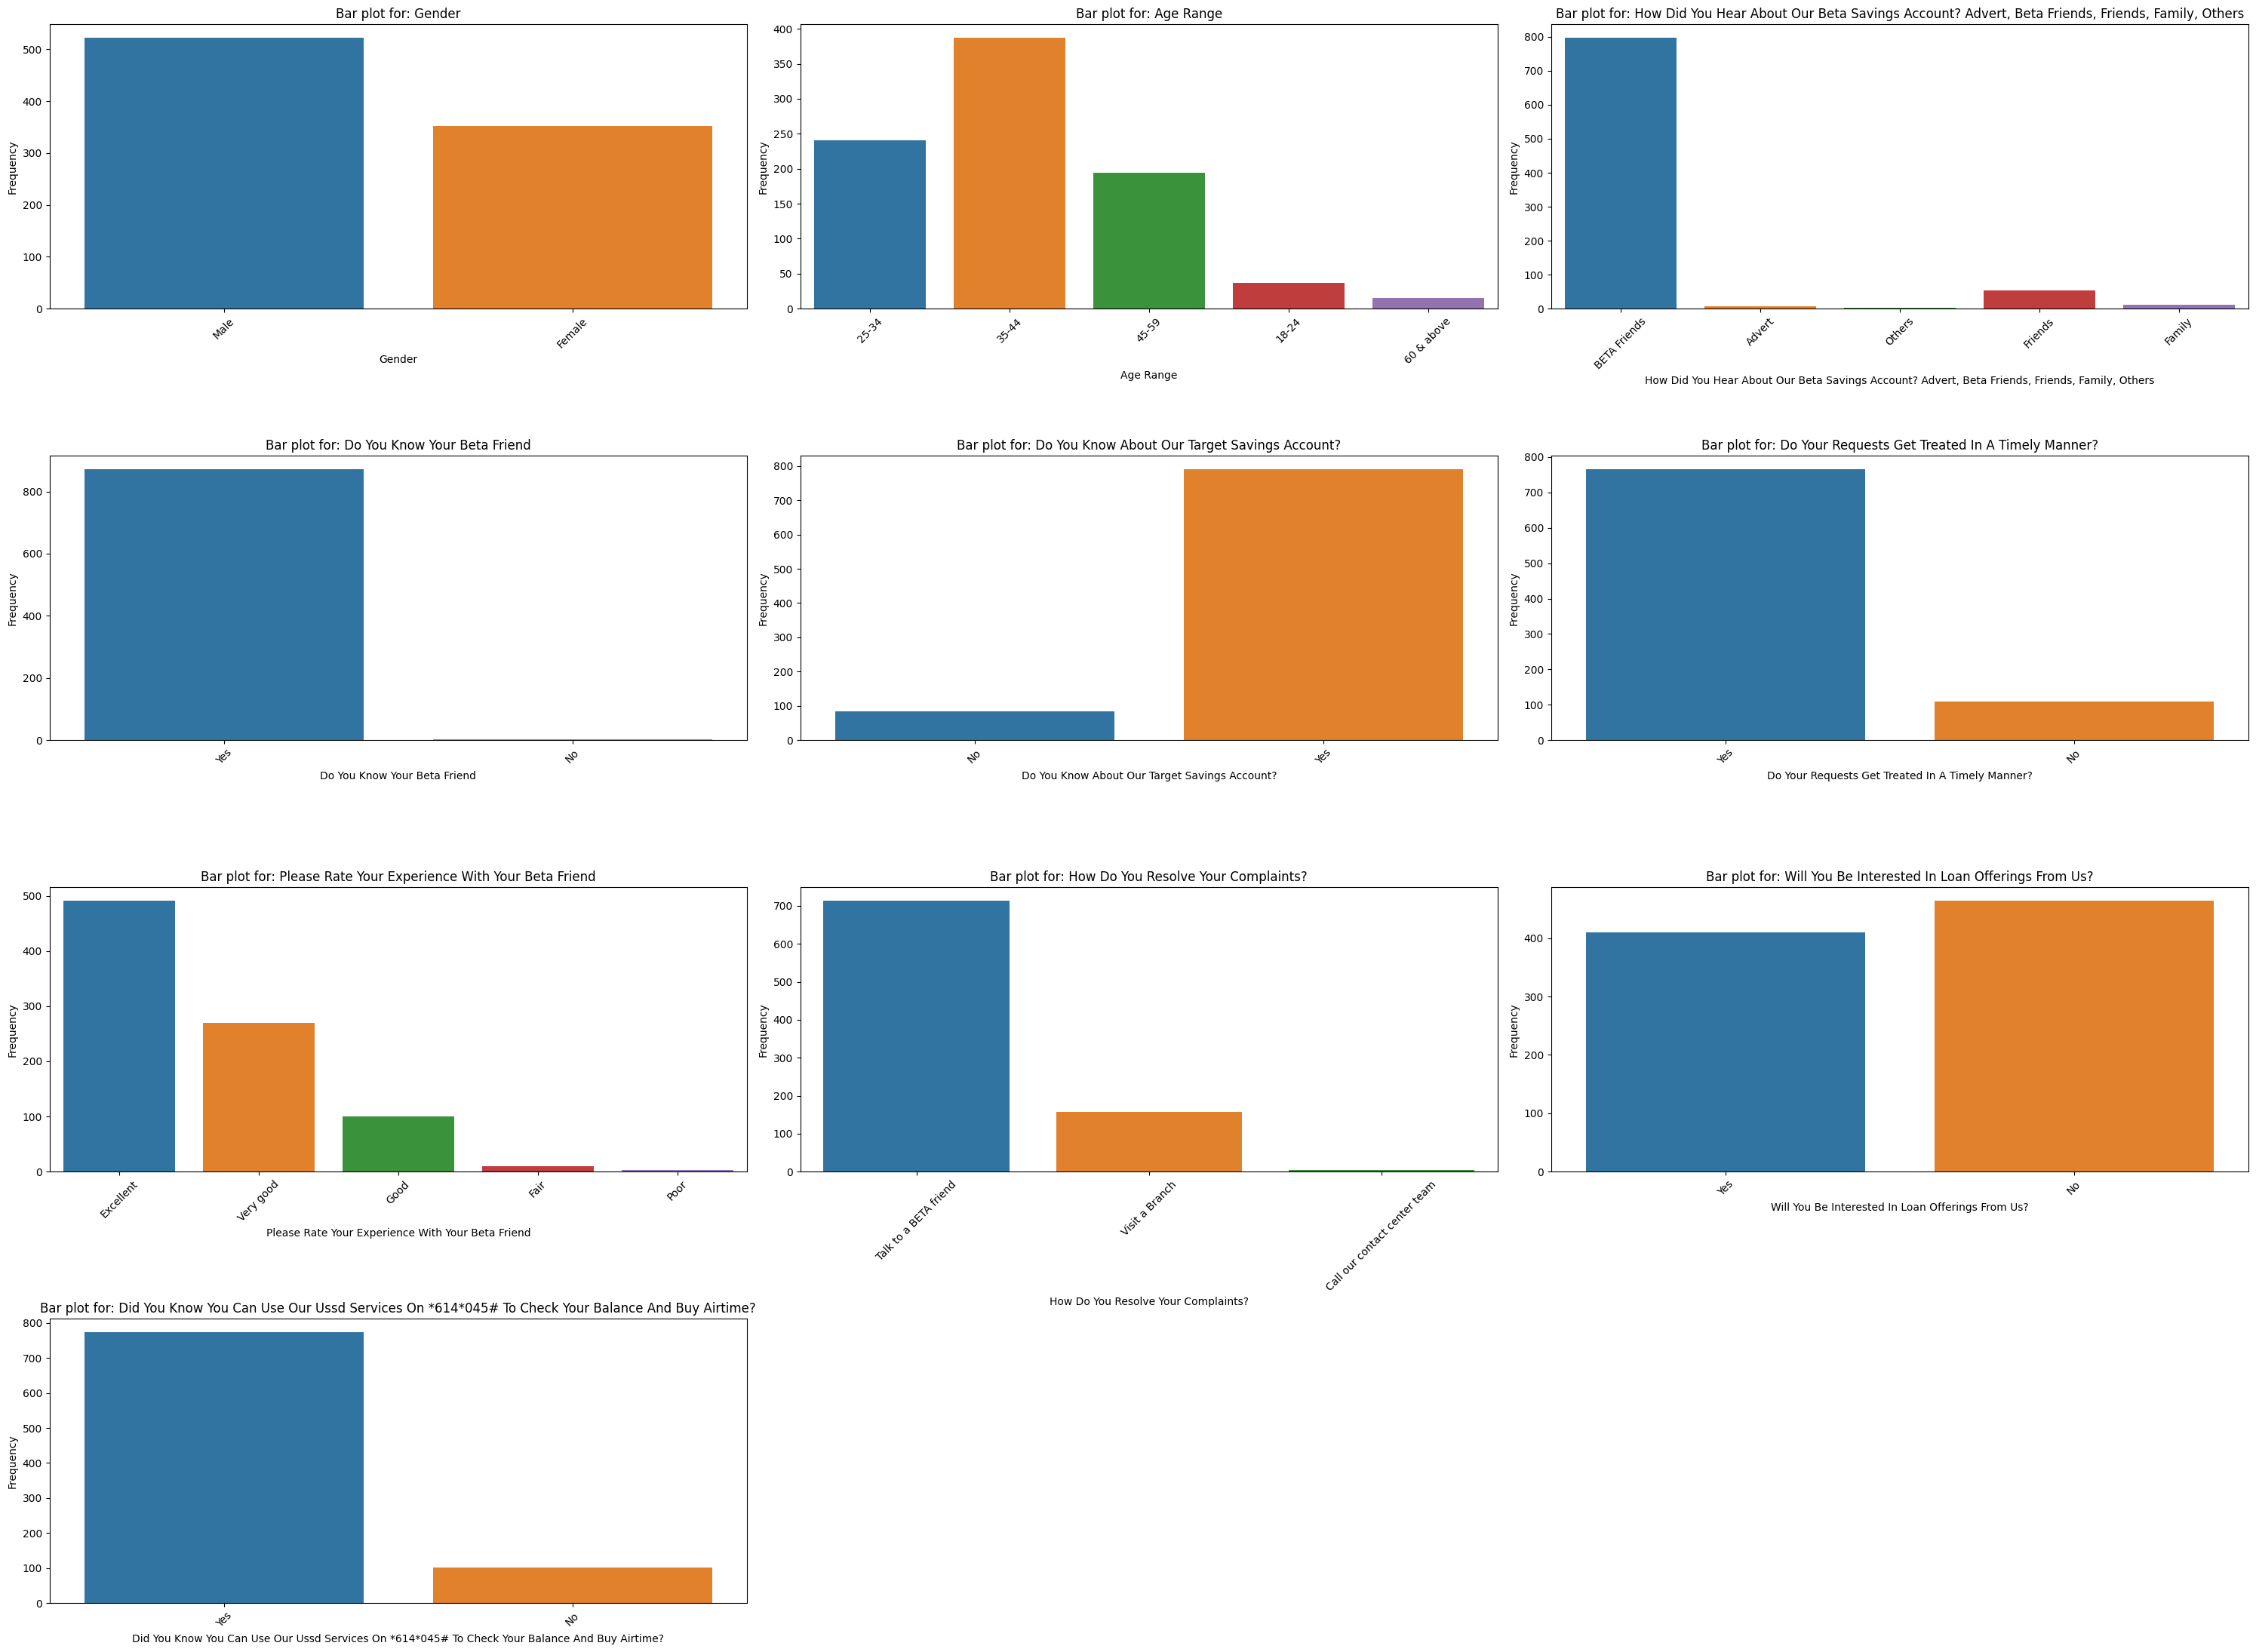

In [14]:
# Plot categorical variables
cat_plot(data=df, features=cat_var.columns)

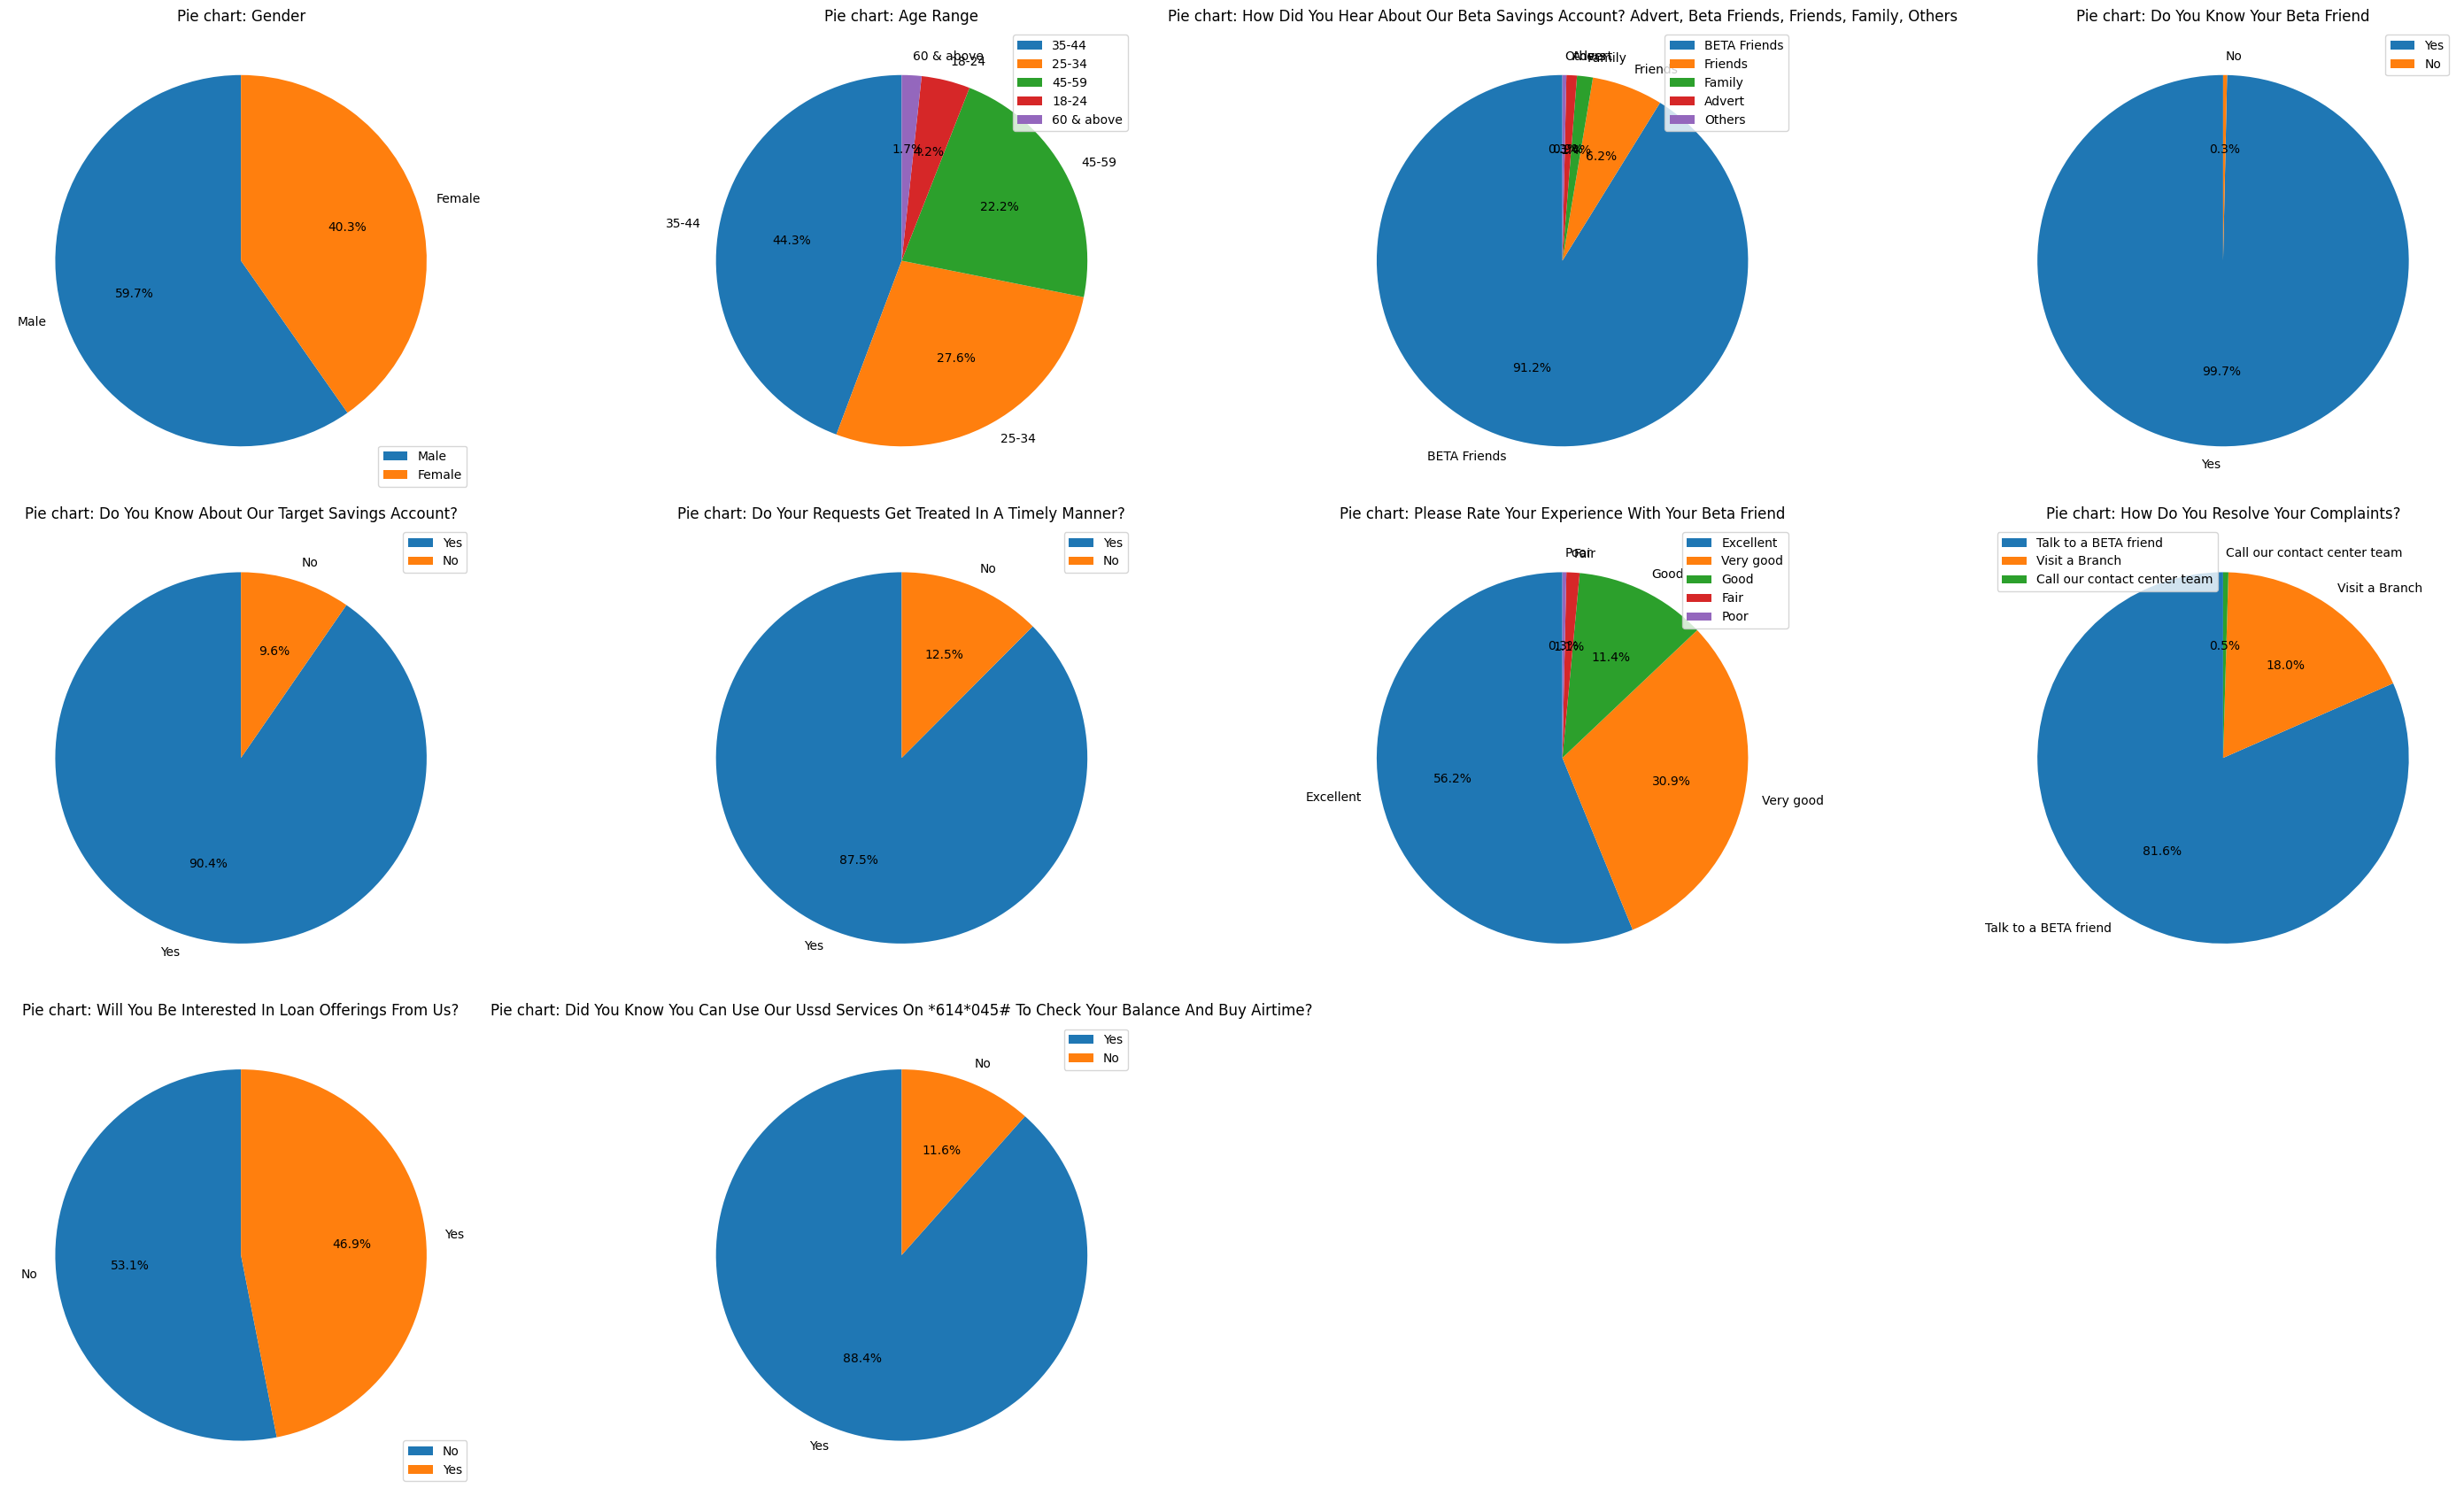

In [15]:
# Making plot of pie charts for categorical variables
cat_pie_plot(data=df, features=cat_var.columns)

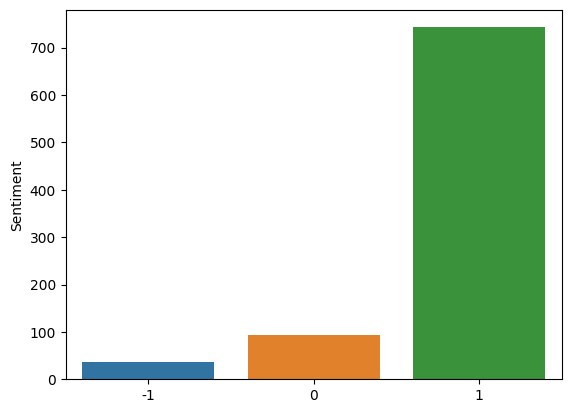

In [114]:
indx = df["Sentiment"].value_counts().index
freq = df["Sentiment"].value_counts()
sns.barplot(data=df, x=indx, y=freq);


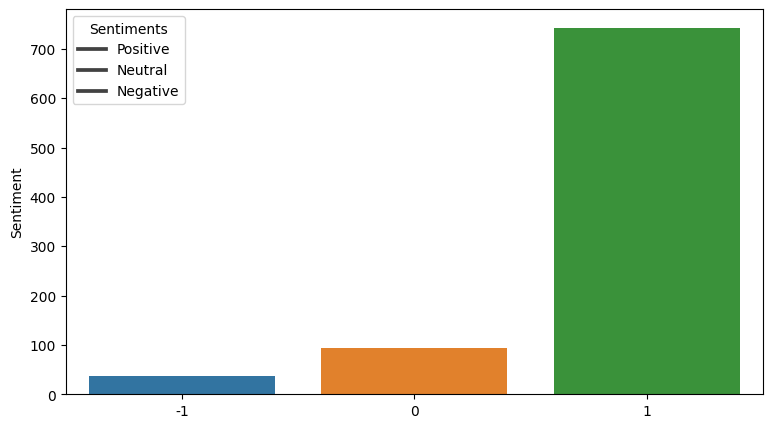

In [117]:
# Plot sentiment bar chart
sentiment_bar_plot(data=df, feat="Sentiment")


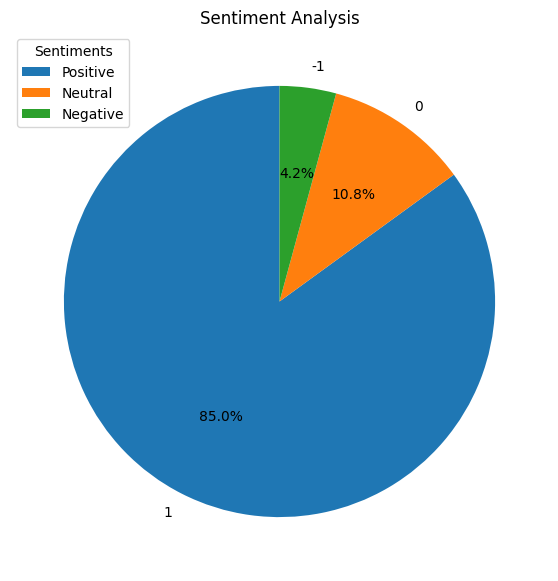

In [116]:
pie_plot(data=df, feat="Sentiment")

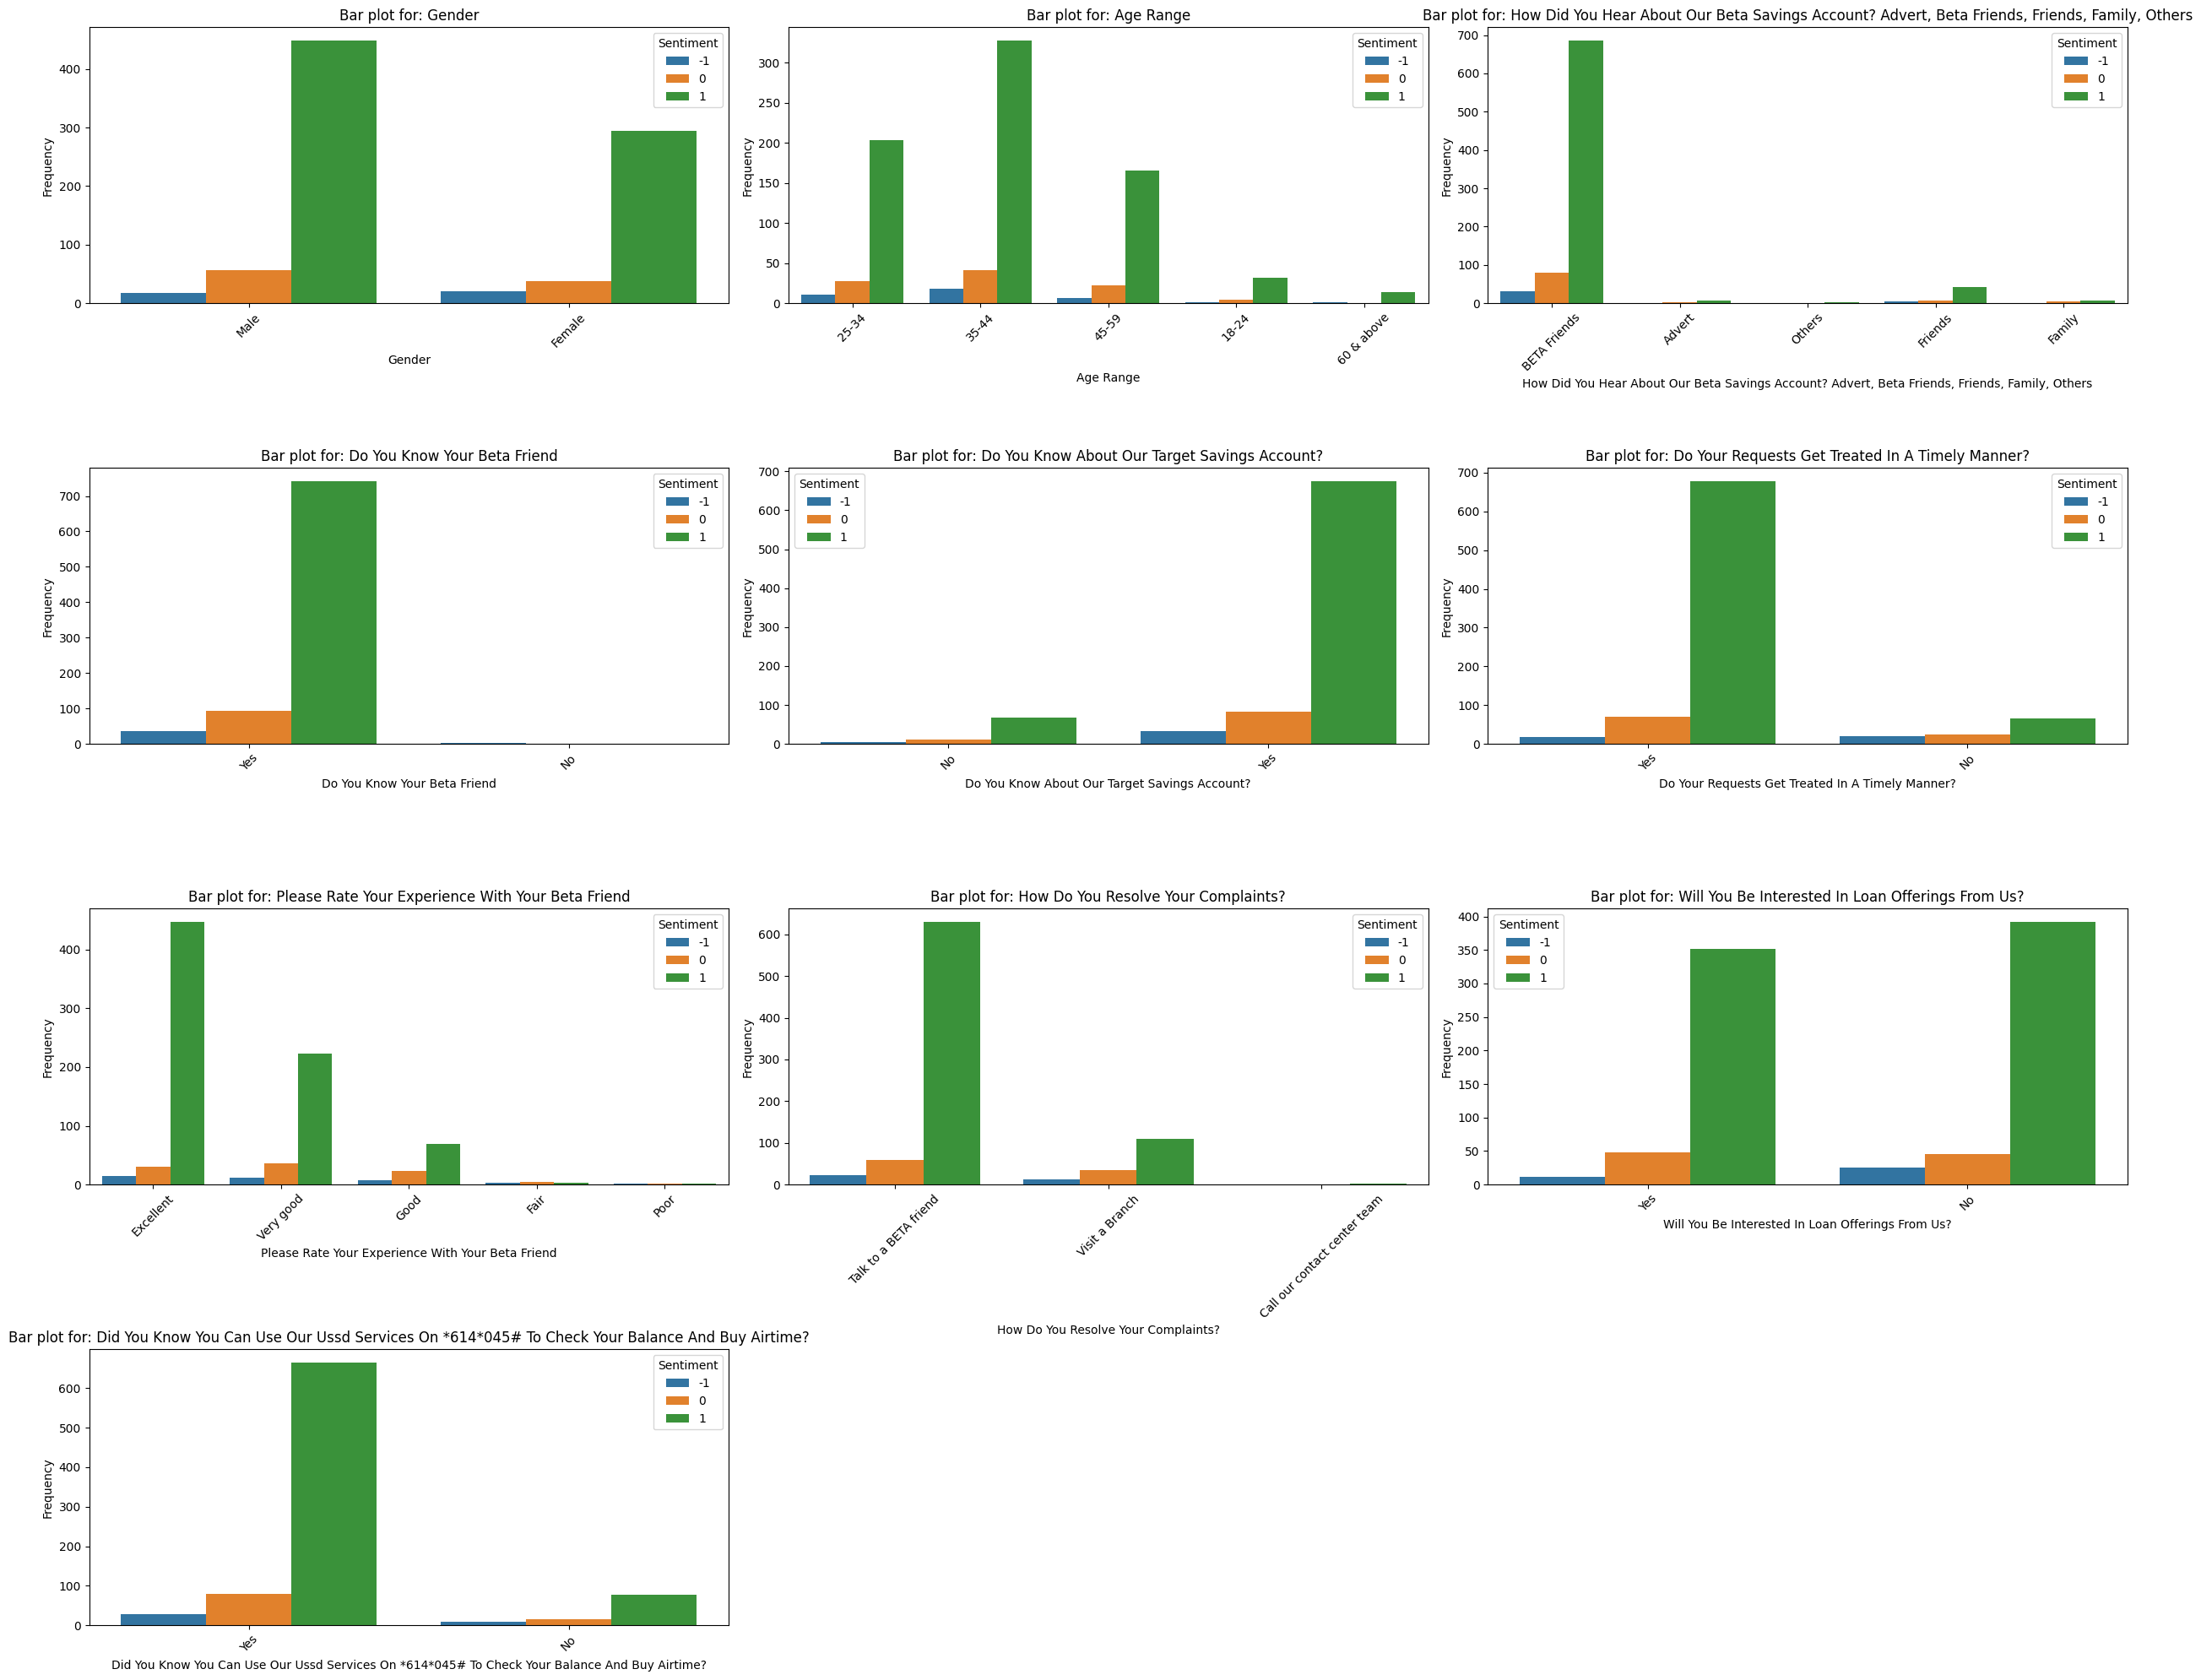

In [103]:
# Bivariate plot
bar_plot(data=df, features=cat_var.columns, other=df["Sentiment"])

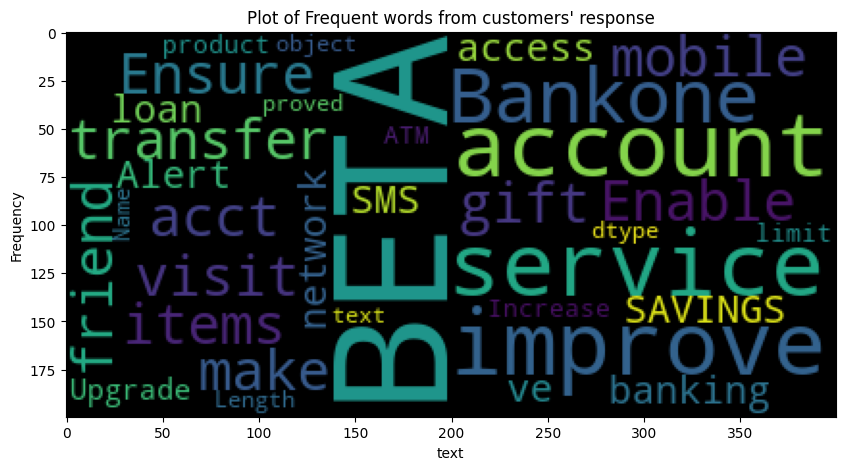

In [105]:
# Plot frequent words from customers' feedback
plot_freq_word(data=df, feature="text", title="Frequent words from customers' response")

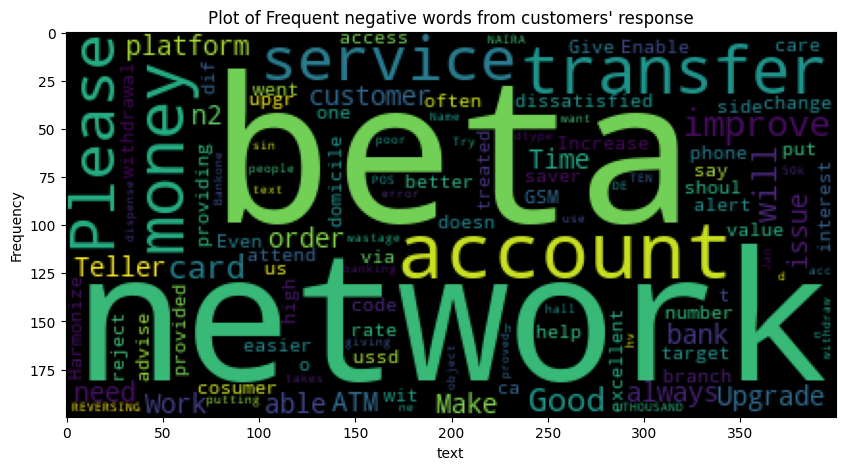

In [106]:
# Plot frequent words from customers' negative sentiment
mask = df["Sentiment"] == -1
# Subset dataset
negative_sent = df[mask]
# Plot frequent
plot_freq_word(data=negative_sent, feature="text", title="Frequent negative words from customers' response")

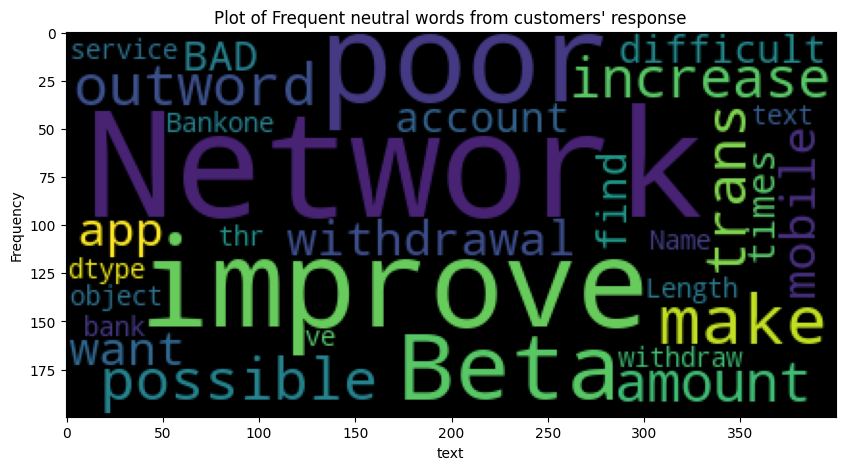

In [107]:
# Plot frequent words from customers' neutral sentiment
mask2 = df["Sentiment"] == 0
# Subset dataset
neut_sent = df[mask2]
# Plot frequent
plot_freq_word(data=neut_sent, feature="text", title="Frequent neutral words from customers' response")

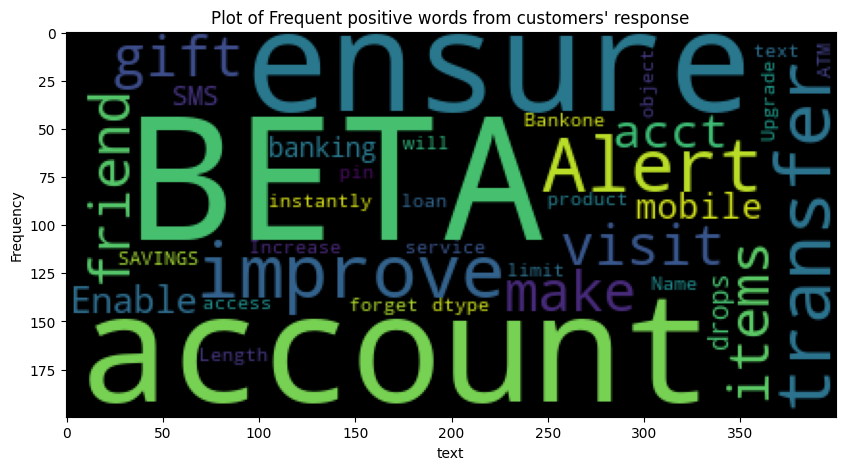

In [108]:
# Plot frequent words from customers' positive sentiment
mask3 = df["Sentiment"] == 1
# Subset dataset
posit_sent = df[mask3]
# Plot frequent
plot_freq_word(data=posit_sent, feature="text", title="Frequent positive words from customers' response")

### Split data

**Normal Dataset**

In [36]:
# Selecting the feature variable and the target vector or label variable
X = vectorizer
y = df["Sentiment"]

In [37]:
# Split the feature variable and target variable into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.2)

In [38]:
# Checking the dimensions of the train and test datasets
print(f"Shape of X_train and y_train: {X_train.shape}, {y_train.shape}")
print(f"Shape of X_test and y_test: {X_test.shape}, {y_test.shape}")

Shape of X_train and y_train: (694, 843), (694,)
Shape of X_test and y_test: (174, 843), (174,)


In [39]:
# Investigate spread of label variable datapoints
y.value_counts(normalize=True)

 1    0.851382
 0    0.105991
-1    0.042627
Name: Sentiment, dtype: float64

Since the label datapoints are not evenly distributed, it will be oversampled 

**Oversample dataset**

In [40]:
# Instantiate and fit the oversampler class
over_sampler = RandomOverSampler(random_state=42)
X_over, y_over = over_sampler.fit_resample(X, y)

# Split the new datasets into train and test
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over,y_over,
                                                                        random_state=42, test_size=0.2)

In [41]:
# Checking the dimensions of the train and test datasets
print(f"Shape of X_train_over and y_train_over: {X_train_over.shape}, {y_train_over.shape}")
print(f"Shape of X_test_over and y_test_over: {X_test_over.shape}, {y_test_over.shape}")

Shape of X_train_over and y_train_over: (1773, 843), (1773,)
Shape of X_test_over and y_test_over: (444, 843), (444,)


## Model Building

Baseline Model: Normal dataset

In [42]:
# Get the baseline accuracy using y_train
baseline_acc = y_train.value_counts(normalize=True).max()
print(f"Baseline accuracy: {round(baseline_acc,4)}")

Baseline accuracy: 0.8401


**Oversampled dataset**

In [43]:
# Get the baseline accuracy using oversampler
baseline_acc_over = y_train_over.value_counts(normalize=True).max()
print(f"Oversampler baseline accuracy: {round(baseline_acc_over,4)}")

Oversampler baseline accuracy: 0.3424


### Train Model

In [44]:
# Instantiate and fit the model using CountVectorizer
model_logit = LogisticRegression(random_state=42, n_jobs=-1).fit(X_train, y_train)

# Instantiate and fit the model using oversampler from CountVectorizer
model_logit_over = LogisticRegression(random_state=42,n_jobs=-1).fit(X_train_over, y_train_over)

### Evaluate Model

In [45]:
# Predict with the test dataset
y_test_pred = predict_label(X=X_test, model=model_logit)

In [46]:
# Compare true and predicted label variables using CountVectorizer
predicted_result(y_true=y_test, y_pred=y_test_pred)[:10]


,y_true,y_pred,error_term
413,0,1,-1
66,1,1,0
514,1,1,0
67,1,1,0
907,1,1,0
813,1,1,0
86,1,1,0
855,1,1,0
636,1,1,0
486,1,0,1


In [47]:
# Get probability score using CountVectorizer
y_test_proba = proba_test_score(model=model_logit, X=X_test)

In [48]:
# Evaluate the model performance on test dataset
eval_metrics(y_true=y_test, y_pred=y_test_pred, y_proba=y_test_proba)

{'accuracy': 0.8678, 'precision': 0.8297, 'recall': 0.8678, 'f1_score': 0.8469}

In [49]:
# Get classification report
result = classification_report(y_true=y_test, y_pred=y_test_pred)
print(result)

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         4
           0       0.25      0.14      0.18        14
           1       0.90      0.96      0.93       156

    accuracy                           0.87       174
   macro avg       0.38      0.37      0.37       174
weighted avg       0.83      0.87      0.85       174



**Oversample**

In [50]:
# Predict with the test dataset
y_test_pred_over = predict_label(X=X_test_over, model=model_logit_over)

In [51]:
# Compare true and predicted label variables oversampler
predicted_result(y_true=y_test_over, y_pred=y_test_pred_over)[:10]

,y_true,y_pred,error_term
948,-1,-1,0
218,1,1,0
1080,-1,-1,0
414,0,0,0
2012,0,0,0
530,1,1,0
1785,0,0,0
1692,0,0,0
981,-1,-1,0
963,-1,-1,0


In [52]:
# Get probability score using oversampler
y_test_proba_over = proba_test_score(model=model_logit_over, X=X_test_over)

In [53]:
# Evaluate the model performance on test dataset
eval_metrics(y_true=y_test_over, y_pred=y_test_pred_over, y_proba=y_test_proba_over)

{'accuracy': 0.9122, 'precision': 0.9155, 'recall': 0.9122, 'f1_score': 0.9122}

In [54]:
# Get classification report
result = classification_report(y_true=y_test_over, y_pred=y_test_pred_over)
print(result)

              precision    recall  f1-score   support

          -1       0.95      0.94      0.95       132
           0       0.86      0.95      0.90       157
           1       0.94      0.85      0.89       155

    accuracy                           0.91       444
   macro avg       0.92      0.91      0.91       444
weighted avg       0.92      0.91      0.91       444



#### Compare with other models

**Using normal train and test dataset**

In [55]:
# Instantiate models
# Logit model
model_mtnb = MultinomialNB().fit(X_train, y_train)

# Decision Tree Classifier
model_dclf = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

# RandomForest Classifier
model_rfc = RandomForestClassifier(random_state=42, n_estimators=150,criterion="gini",
                                   max_depth=10).fit(X_train, y_train)

# KNeighborsClassifier
model_knc = KNeighborsClassifier(n_neighbors=5,weights="uniform",
                                 metric="minkowski").fit(X_train, y_train)

# SVC
model_svc = SVC(kernel="linear").fit(X_train, y_train)

In [56]:
# Evaluate performance of models
eval_best_model(model_1=model_logit, model_2=model_mtnb, 
                model_3=model_dclf, model_4=model_rfc, model_5=model_knc, 
                model_6=model_svc,X_train=X_train, X_test=X_test, 
                y_train=y_train, y_test=y_test)

Model accuracy for:LogisticRegression(n_jobs=-1, random_state=42)
Training Accuracy: 0.9251
Test Accuracy: 0.8678
Model accuracy for:MultinomialNB()
Training Accuracy: 0.902
Test Accuracy: 0.8793
Model accuracy for:DecisionTreeClassifier(random_state=42)
Training Accuracy: 0.9813
Test Accuracy: 0.7874
Model accuracy for:RandomForestClassifier(max_depth=10, n_estimators=150, random_state=42)
Training Accuracy: 0.8429
Test Accuracy: 0.8966
Model accuracy for:KNeighborsClassifier()
Training Accuracy: 0.8487
Test Accuracy: 0.8966
Model accuracy for:SVC(kernel='linear')
Training Accuracy: 0.9452
Test Accuracy: 0.8506


**Using oversampler train and test datasets to evaluate performance of models**

In [57]:
# Instantiate models
# Logit model
model_mtnb_over = MultinomialNB().fit(X_train_over, y_train_over)

# Decision Tree Classifier
model_dclf_over = DecisionTreeClassifier(random_state=42).fit(X_train_over, y_train_over)

# RandomForest Classifier
model_rfc_over = RandomForestClassifier(random_state=42, n_estimators=150,criterion="gini",
                                   max_depth=10).fit(X_train_over, y_train_over)

# KNeighborsClassifier
model_knc_over = KNeighborsClassifier(n_neighbors=5,weights="uniform",
                                 metric="minkowski").fit(X_train_over, y_train_over)

# SVC
model_svc_over = SVC(kernel="linear").fit(X_train_over, y_train_over)

In [58]:
# Evaluate performance of models
eval_best_model(model_1=model_logit_over, model_2=model_mtnb_over, 
                model_3=model_dclf_over, model_4=model_rfc_over, model_5=model_knc_over, 
                model_6=model_svc_over,X_train=X_train_over, X_test=X_test_over, 
                y_train=y_train_over, y_test=y_test_over)

Model accuracy for:LogisticRegression(n_jobs=-1, random_state=42)
Training Accuracy: 0.9447
Test Accuracy: 0.9122
Model accuracy for:MultinomialNB()
Training Accuracy: 0.8556
Test Accuracy: 0.8401
Model accuracy for:DecisionTreeClassifier(random_state=42)
Training Accuracy: 0.9667
Test Accuracy: 0.9099
Model accuracy for:RandomForestClassifier(max_depth=10, n_estimators=150, random_state=42)
Training Accuracy: 0.7975
Test Accuracy: 0.7365
Model accuracy for:KNeighborsClassifier()
Training Accuracy: 0.9036
Test Accuracy: 0.8581
Model accuracy for:SVC(kernel='linear')
Training Accuracy: 0.9515
Test Accuracy: 0.9077


## Communicate Result

From the comparison of models given above, the oversampler performed better and the  `LogisticRegression` model performed better than other models. I decided to investigate the confusion matrix using `LogisticRegression` model.

Hence, I used the `oversampler LogisticRegression` to build the model and saved both the `Logistic Regression` and `DecisionTreeClassifier` models were saved as they were the `best performing` models.

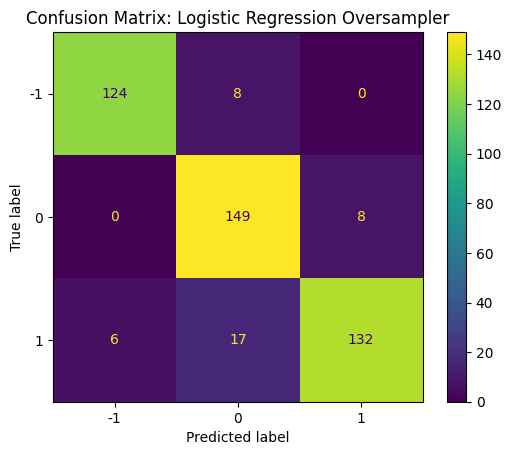

In [59]:
# Get the confusion matrix for logistic regression model
confusion_mat(model=model_logit_over, X=X_test_over, y=y_test_over, model_name="Logistic Regression Oversampler")

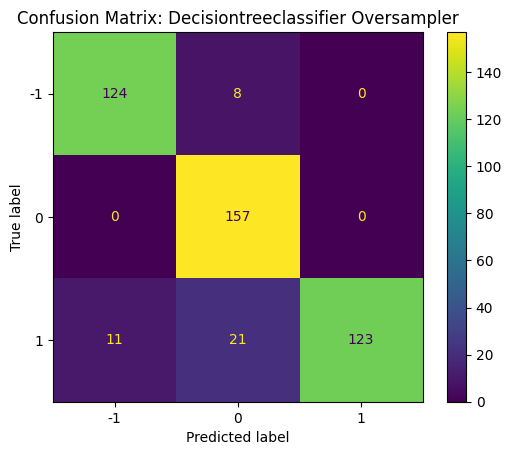

In [60]:
# Get the confusion matrix for DecisionTreeClassifier model to compare with logistic regression model
confusion_mat(model=model_dclf_over, X=X_test_over, y=y_test_over, 
              model_name="DecisionTreeClassifier Oversampler")

### Save Model

In [62]:
save_model(model=model_logit_over, filename="model_logit_bk")
save_model(model=model_dclf_over, filename="model_rfc_bk")

### `Observations:`

The following conclusions are drawn from the analysis:

1. More male customers attended to the survey questionnaire than the female customers in the ratio: 60/40.
2. More customers in age bracket 35-44 with counts 384 attended to the survey questionnaire, while customers in age bracket 60 & above have the least number of attendants with counts 15.
3. Much customers expressed positive sentiment with regards their satisfaction with the bank's product. These are likely to recommend the bank's products and services to propective customers and they represent about 85%.
4. The likelihood of customers to churn the bank's products and services is less in comparison to the ones that could be retained across all parameters.  
5. The number of customers interested in the bank's loan are less compared to the ones that declined interest. The ratio is 47%:53%
6. The number of customers that are aware of using USSD Code on the bank's account are more than those who are unaware in the ratio of 88%:12%
7. About 87% of the customers said that their requests were treated in a timely manner, while 13% said their requests were not timely resolved.
8. Majority of the customers are aware of target savers account. This represents about 90% of the sampled customers.
9. Many of the customers representing about `91%` said they got to hear about the bank's account from BETA agents.
10. About `99.7%` of the customers said they know their BETA Friends, while very few of them about `0.3%` said they are unaware of their BETA Friends.
11. In resolving complaints on BETA accounts: `81.6%` said they contacted and reported complaints to BETA agents, `18.0%` said they visited the branch, while `0.5%` of the customers contacted the bank's customer care line.

### `Some possible causes of the problem:`

Some of the possible causes of the negative feedback from our customers could stem as a result of the following:

1. Regular interruption on the bank’s transactional platform (Bankone)
2. Poor customer service
3. Delay in resolving customers’ complaints across the bank’s conventional channels
4. Poor education and enlightenment of customer about BETA products and services.
5. Poor attitude of BETA Friends towards providing quality services to their customers.

### `Recommendations:`

To following recommendations, if implemented, might assist the bank to increase customer base and boost deposit volume:

1. Invest in improving customer service, upgrading technology infrastructure, streamlining banking processes, and offering innovative and competitive products. Focus on creating a seamless and user-friendly experience across digital and physical channels.
2. Leverage customer feedback to tailor products, services, and marketing campaigns to better meet customer needs and preferences. Offer personalized experiences and targeted promotions to enhance customer satisfaction and engagement.
3. Continuously adapt strategies based on customer insights, market dynamics, and emerging trends.

### `Conclusion:`

The bank stands to benefit the following if the customers’ problems highlighted are solved:

1. Increased customer acquisition
2. Growth in deposit volume
3. Overall enhanced financial performance
4. Competitive advantage over its competitors.

